# import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import warnings
import tes_analysis_tools as tat
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
# from tsfresh.feature_extraction import extract_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.utilities.distribution import MultiprocessingDistributor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
sns.set()
warnings.filterwarnings('ignore')

# utils

In [3]:
# データ補正 <- 18次回帰曲線
def regression(data, time):
    fit = np.polyfit(time, data, 18)
    fit_fn = np.poly1d(fit)
    return fit_fn(time)

# 標準化
def standardize(df):
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_std

# 主成分分析の特徴量に対する前処理
# 第一主成分の平均値が低いクラスタから0, 1, ...と再ラベリング
def relabel_by_first_component_avg(label_col, pca_df):
    relabeled_pca_df = pca_df.copy()
    first_component_avg_per_cluster = {}
    for label in set(pca_df[label_col]):
        if label != -1:
            first_component_avg_per_cluster[label] = pca_df[pca_df[label_col] == label]["first_component"].mean()
    sorted_keys = sorted(first_component_avg_per_cluster, key=lambda x: first_component_avg_per_cluster[x])
    relabel_dict = {k: v for v, k in enumerate(sorted_keys)}
    relabel_dict[-1] = -1
    relabeled_pca_df[label_col] = relabeled_pca_df[label_col].map(relabel_dict)
    return relabeled_pca_df

# データ読み込み、作成

Shaping ... 
number of selected pulses =  10000


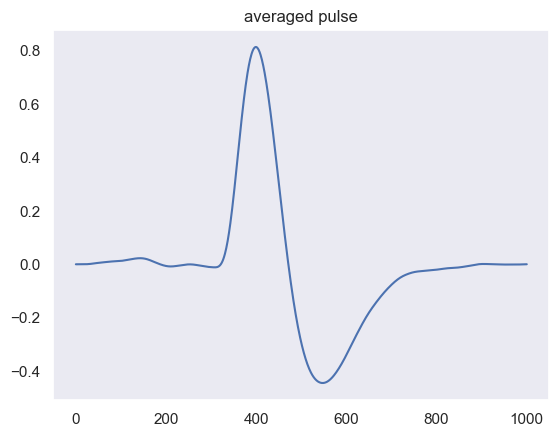

max pulse height =  0.014150716822372296
min pulse height =  8.63413854979736e-06


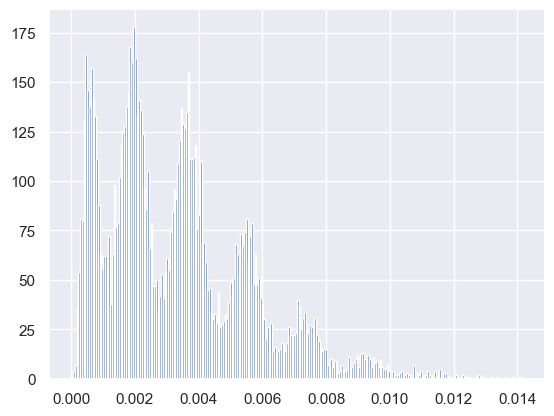

Optimal filtering started ...
|N(f)|^2 =  [0.46481942 0.30328074 0.31248413 ... 0.3262508  0.31248413 0.30328074]
|M(f)|^2 =  [8.82221935e-03 4.91831404e+03 9.47976336e+03 ... 8.81802291e+03
 9.47976336e+03 4.91831404e+03]
max frequency =  1000000.0
max frequency index =  50
0.0 %  ( 0 pulses processed )


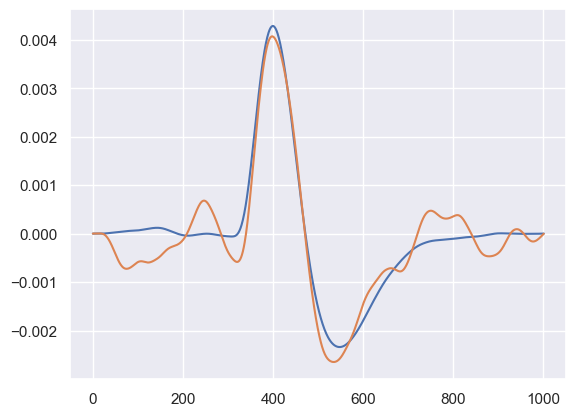

10.0 %  ( 1000 pulses processed )


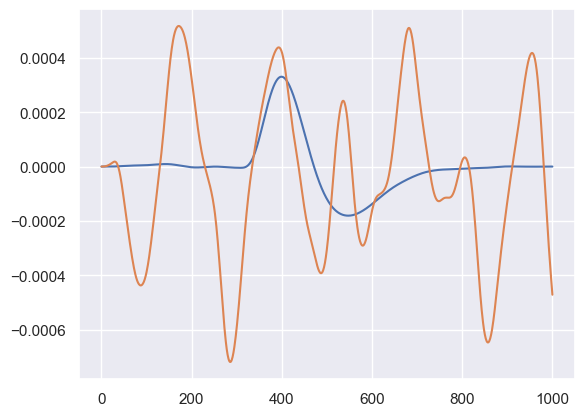

20.0 %  ( 2000 pulses processed )


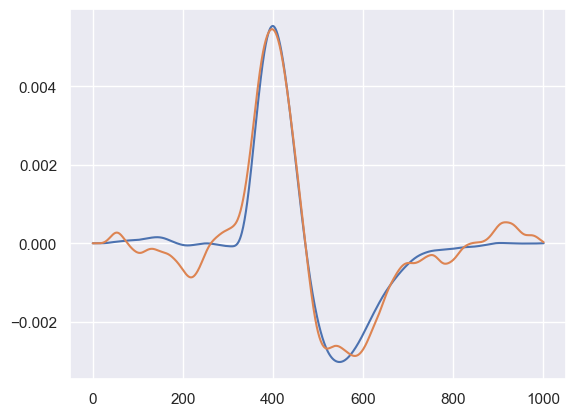

30.0 %  ( 3000 pulses processed )


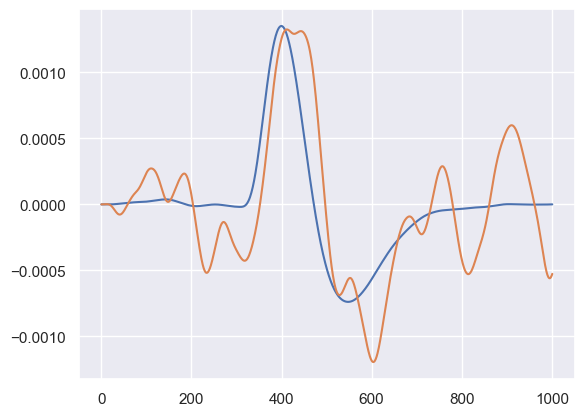

40.0 %  ( 4000 pulses processed )


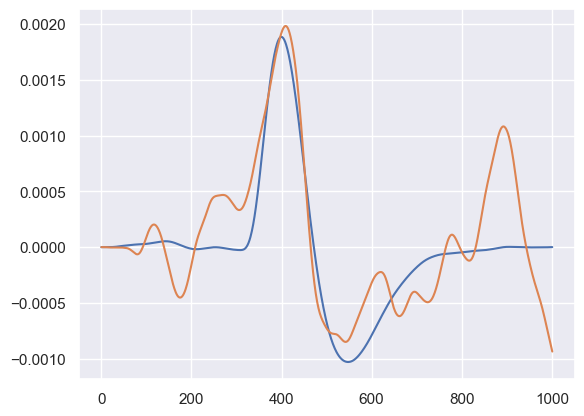

50.0 %  ( 5000 pulses processed )


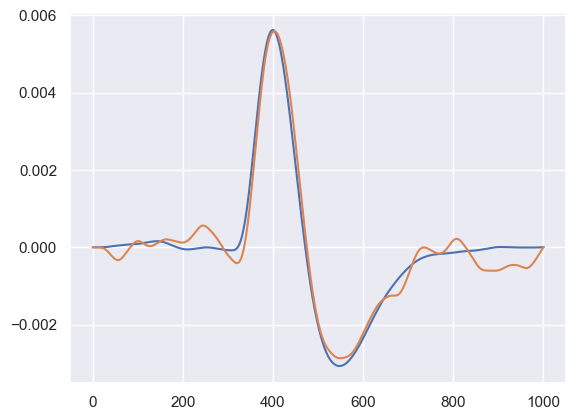

60.0 %  ( 6000 pulses processed )


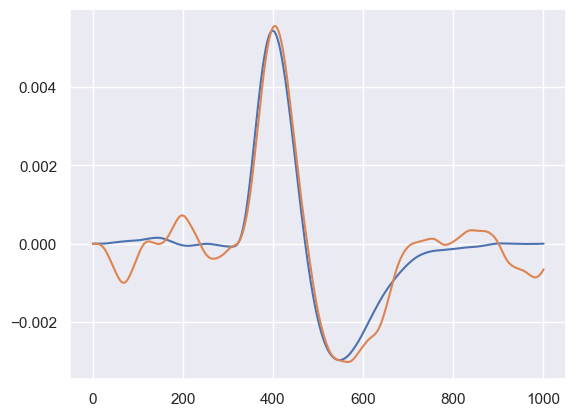

70.0 %  ( 7000 pulses processed )


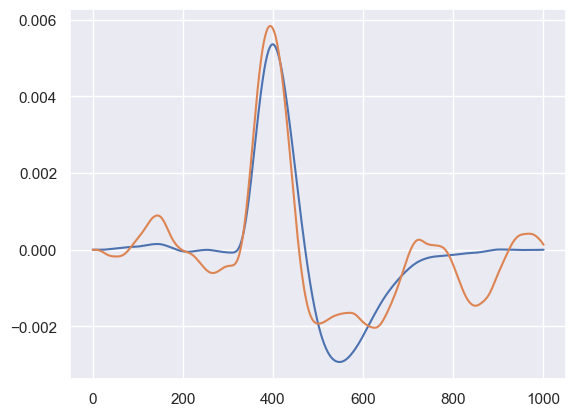

80.0 %  ( 8000 pulses processed )


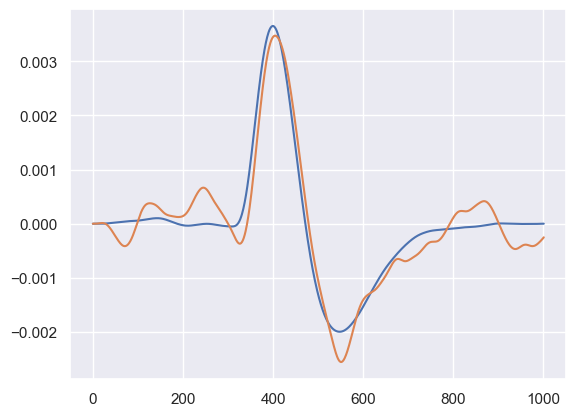

90.0 %  ( 9000 pulses processed )


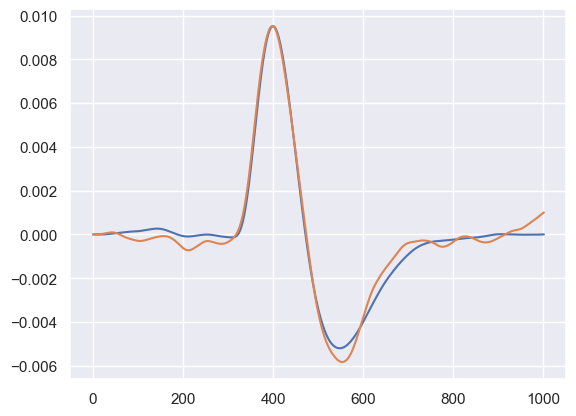

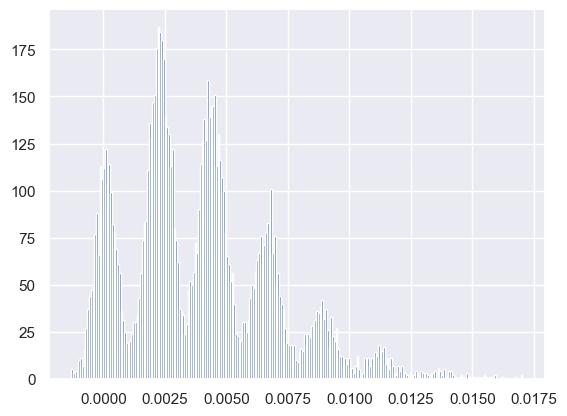

Optimal filtering done.


In [4]:
# -----------------------
# データ読み込み
# -----------------------

dir = "../WF/exp1/"
savedir = "./exp1_result/"
pulse = np.load(dir + "pulse.npy")
noise = np.load(dir + "noise.npy")
time = np.load(dir + "time.npy")

n = pulse.shape[0]
dp = pulse.shape[1]
m = noise.shape[0]
dt = time[1] - time[0]

# baseline 補正, 先頭からdpbl点の平均をoffsetとして引き去る
dpbl = 200
pulse = tat.correct_baseline(pulse, dpbl)

# 正負反転
pulse = -1.0 * pulse

# ------------------------------------
#  従来型の波形処理
# ------------------------------------

# 波形整形
pulse = tat.shaping(pulse, dt, 1.0e-6, 1.0e-6, True)

# 平均波形
avg = tat.make_average_pulse(pulse, 0.0, 1.0, 200, 500, True, True, True)

# 単純波高値
tat.simple_ph_spectrum(pulse, 200, 500, True, True)

# 最適フィルタ
ph, hist = tat.optimal_filter_freq(pulse, avg, noise, dt, 1.0e6, True, True)

# ------------------------------------
#  
# ------------------------------------

# テストデータ
test_df = pd.DataFrame(pulse)

# テストデータを曲線にフィッティングする場合
test_df = test_df.apply(regression, args=(time,), axis=1, result_type="expand")

# 教師なしクラスタリング

## 主成分分析

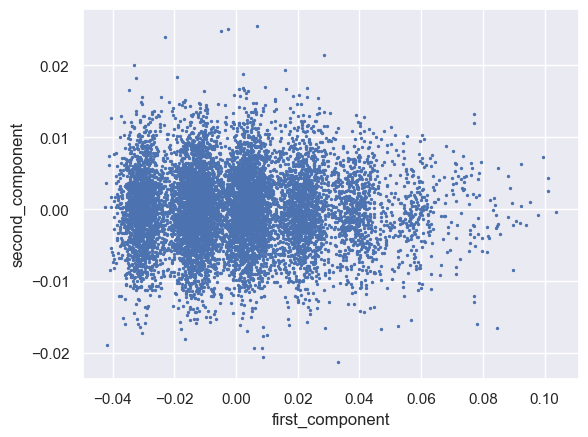

In [5]:
# 主成分分析
pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(test_df.values)
pca_df = pd.DataFrame(data=X_pca, columns=["first_component", "second_component"])
pca_df.plot.scatter(x="first_component", y="second_component", s=2)
plt.show()

In [6]:
# K-Means
kmeans_model = KMeans(n_clusters=6)
y_pred_kmeans = kmeans_model.fit_predict(pca_df.values)

# DBSCAN
dbscan_model = DBSCAN(eps=0.00155, min_samples=50)
y_pred_dbscan = dbscan_model.fit_predict(pca_df.values)

pca_df["kmeans_pred"] = y_pred_kmeans
pca_df["dbscan_pred"] = y_pred_dbscan

pca_df = relabel_by_first_component_avg(label_col="kmeans_pred", pca_df=pca_df)
pca_df = relabel_by_first_component_avg(label_col="dbscan_pred", pca_df=pca_df)

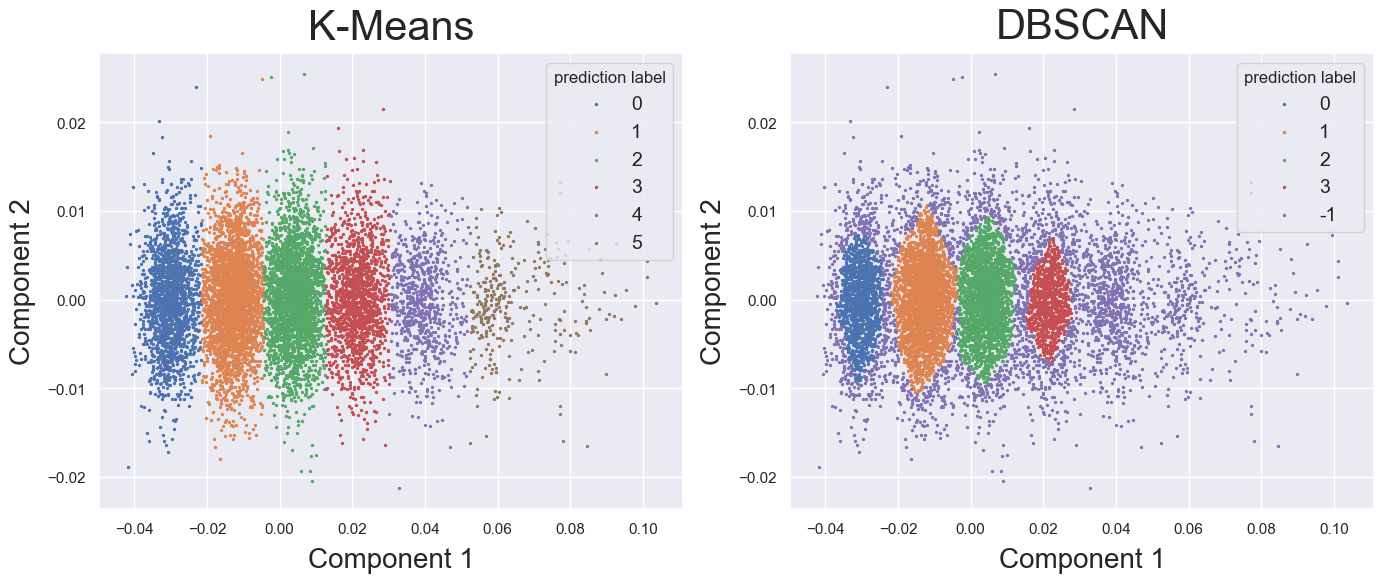

In [23]:
# クラスタリング結果
fig, ax = plt.subplots(1, 2, figsize=(14,6), tight_layout=True)

for photon_count in set(pca_df["kmeans_pred"]):
    ax[0].scatter(pca_df[pca_df["kmeans_pred"]==photon_count]["first_component"], pca_df[pca_df["kmeans_pred"]==photon_count]["second_component"], s=2, label=photon_count)

for photon_count in set(pca_df["dbscan_pred"]):
    ax[1].scatter(pca_df[pca_df["dbscan_pred"]==photon_count]["first_component"], pca_df[pca_df["dbscan_pred"]==photon_count]["second_component"], s=2, label=photon_count)

ax[0].set_title("K-Means", fontsize=30, pad=10.0)
ax[0].set_xlabel("Component 1", fontsize=20, labelpad=8.0)
ax[0].set_ylabel("Component 2", fontsize=20, labelpad=8.0)
ax[1].set_title("DBSCAN", fontsize=30, pad=10.0)
ax[1].set_xlabel("Component 1", fontsize=20, labelpad=8.0)
ax[1].set_ylabel("Component 2", fontsize=20, labelpad=8.0)
ax[0].legend(title="prediction label", fontsize=14)
ax[1].legend(title="prediction label", fontsize=14)
plt.savefig("../images/pca_clustering.png")
# plt.show()

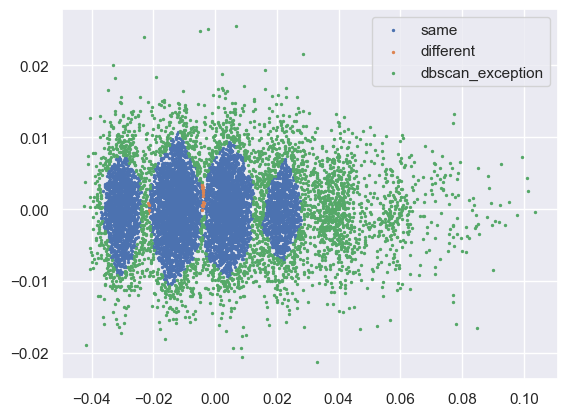

In [19]:
# K-MeansとDBSCANで予測が同じもの、異なるものを確認
same_pred = pca_df[pca_df["kmeans_pred"]==pca_df["dbscan_pred"]]
different_pred = pca_df[(pca_df["dbscan_pred"] != pca_df["kmeans_pred"]) & (pca_df["dbscan_pred"] != -1)]
dbscan_exception = pca_df[pca_df["dbscan_pred"]==-1]
plt.scatter(same_pred["first_component"], same_pred["second_component"], s=2, label="same")
plt.scatter(different_pred["first_component"], different_pred["second_component"], s=2, label="different")
plt.scatter(dbscan_exception["first_component"], dbscan_exception["second_component"], s=2, label="dbscan_exception")
plt.legend()
plt.show()

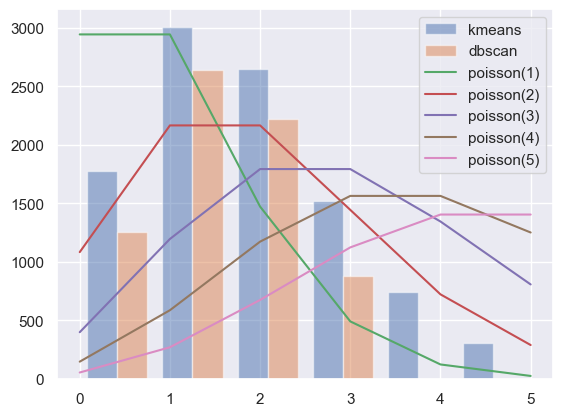

In [20]:
# クラスタのヒストグラムがpoisson分布に従っているか確認
def poisson(x, lam=1):
    return 8000 * (np.e ** (-lam)) * (lam ** x) / math.factorial(x)
x_list = np.arange(0, 6)
lam_list = range(1,6)
y_list_per_lam = {lam: [poisson(x, lam) for x in x_list] for lam in lam_list}

plt.hist([pca_df["kmeans_pred"], pca_df[pca_df["dbscan_pred"]!=-1]["dbscan_pred"]], bins=6, alpha=0.5, label=["kmeans", "dbscan"])
for lam in lam_list:
    plt.plot(x_list, y_list_per_lam[lam], label=f"poisson({lam})")
plt.legend()
plt.show()

# 最適フィルタリングとの比較

In [21]:
df_optimal_filtered = pd.DataFrame(pulse)
df_optimal_filtered["ph"] = ph

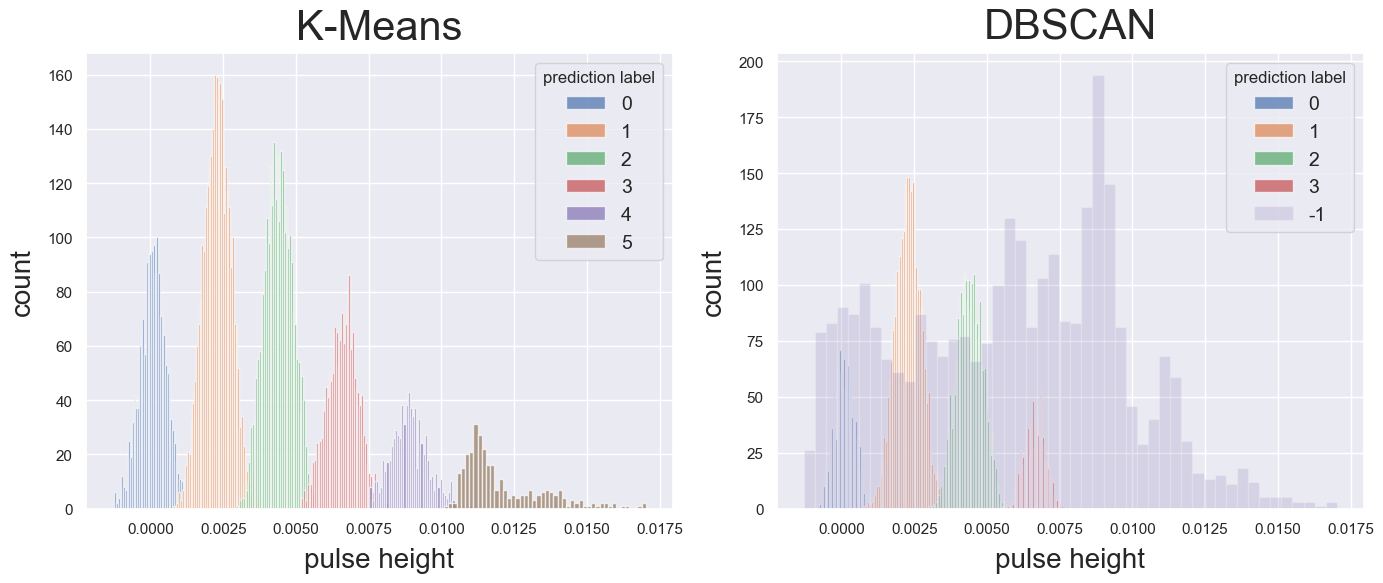

In [28]:
# PCA&クラスタリングの結果と比較 
pca_clustering_optimal_filter_df = pca_df.copy()
pca_clustering_optimal_filter_df["ph"] = df_optimal_filtered["ph"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
for photon_count in set(pca_clustering_optimal_filter_df["kmeans_pred"]):
    ax[0].hist(pca_clustering_optimal_filter_df[pca_clustering_optimal_filter_df["kmeans_pred"]==photon_count]["ph"], bins=48, label=photon_count, alpha=0.7)
for photon_count in set(pca_clustering_optimal_filter_df["dbscan_pred"]):
    if photon_count == -1:
        ax[1].hist(pca_clustering_optimal_filter_df[pca_clustering_optimal_filter_df["dbscan_pred"]==photon_count]["ph"], bins=48, label=photon_count, alpha=0.2)
    else:
        ax[1].hist(pca_clustering_optimal_filter_df[pca_clustering_optimal_filter_df["dbscan_pred"]==photon_count]["ph"], bins=48, label=photon_count, alpha=0.7)

ax[0].set_title("K-Means", fontsize=30, pad=10)
ax[0].set_xlabel("pulse height", fontsize=20, labelpad=8)
ax[0].set_ylabel("count", fontsize=20, labelpad=8)
ax[1].set_title("DBSCAN", fontsize=30, pad=10)
ax[1].set_xlabel("pulse height", fontsize=20, labelpad=8)
ax[1].set_ylabel("count", fontsize=20, labelpad=8)
ax[0].legend(title="prediction label", fontsize=14)
ax[1].legend(title="prediction label", fontsize=14)
plt.savefig("../images/optimal_filter_and_clustering_hist.png")
# plt.show()